<a href="https://colab.research.google.com/github/slp22/deep-learning-project/blob/main/dl_diabetic_retinopathy_mvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Deep Learning | MVP

# Diabetic Retinopathy<a id='top'></a> 

## **Analysis Goal**  
The client, the [National Eye Institute](https://www.nei.nih.gov/), part of the National Institutes of Health, wants a model that can quickly identify [diabetic retinopathy](https://www.nei.nih.gov/learn-about-eye-health/eye-conditions-and-diseases/diabetic-retinopathy) in patients participating in early phase clinical trials.

**RQ:** How well can a neural network diagnose diabetic retinopathy from a retinal image?


## **Process**
**Data source:** [Diabetic Retinopathy](https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-2015-data-colored-resized)retinal images at various stages of the disease, modified from the [Diabetic Retinopathy Detection Kaggle Competition](https://www.kaggle.com/c/diabetic-retinopathy-detection); images are courtesy of [EyePACS](http://eyepacs.com/),a free platform for retinopathy screening. The dataset (n=35,126) is classified as:  
  0 - No_DR (healthy eye)
  1 - Mild
  2 - Moderate
  3 - Severe
  4 - Proliferate_DR

**Error Metric:** Precision and recall 

**Models:** 
  * Baseline model, fit a logistic regression:
    * recall score on X_test and y_test: ###
    * precision score on y_validate and y_predict: ###
    * ROC AUC score: ###
  * First iteration, basic deep learning model:
    * recall score on X_test and y_test: ###
    * precision score on y_validate and y_predict: ###
    * ROC AUC score: ###

## **Preliminary Visualizations**
Figure 1. EDA
Figure 2. ROC Curve ???
Figure 3. ROC Curve ???

## **Preliminary Conclusions**
The baseline logistic regression model scored less well/better on recall and precision that the first iteration deep learning model. 

The next step for this analysis is to classify ... 

In [171]:
# import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import PIL
import seaborn as sns
import sklearn as sk
import tensorflow as tf
import warnings

%pylab inline
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']  # or svg
pd.set_option('display.max_colwidth', None)
sns.set(context='notebook', style='whitegrid')
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing import image as IMG
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Rescaling, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

print("Matplotlib version:", matplotlib.__version__)
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("TensorFlow version:", tf.__version__)
print("Keras Version:", tf.keras.__version__)
print("Scikit-learn version:", sk.__version__)


Populating the interactive namespace from numpy and matplotlib
Matplotlib version: 3.2.2
Numpy version: 1.21.6
Pandas version: 1.3.5
TensorFlow version: 2.8.2
Keras Version: 2.8.0
Scikit-learn version: 1.0.2


## 1 | Dataset: [Diabetic Retinopathy Retinal Images](https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-2015-data-colored-resized)<a id='1'></a>  

Code adapted from [github/PurpleGrace](https://github.com/PurpleGrace/Deep_Learning_Tools_Image_Classification/blob/main/code/1.EDA_Sample_Images.ipynb)


In [4]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sandralparedes","key":"52716e458c895e3e9d7fcfde80b0d59e"}'}

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
! pwd
! ls

/content
drive  kaggle.json  sample_data


In [7]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [8]:
! kaggle datasets download -d sovitrath/diabetic-retinopathy-2015-data-colored-resized

 99% 1.92G/1.94G [00:27<00:00, 83.8MB/s]
100% 1.94G/1.94G [00:27<00:00, 74.7MB/s]


In [9]:
zip_ref = zipfile.ZipFile('diabetic-retinopathy-2015-data-colored-resized.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [156]:
print('No_DR:', len(os.listdir('/tmp/colored_images/colored_images/No_DR')))
print('Mild:', len(os.listdir('/tmp/colored_images/colored_images/Mild')))
print('Moderate:', len(os.listdir('/tmp/colored_images/colored_images/Moderate')))
print('Severe:', len(os.listdir('/tmp/colored_images/colored_images/Severe')))
print('Proliferate_DR:', len(os.listdir('/tmp/colored_images/colored_images/Proliferate_DR')))


No_DR: 25810
Mild: 2443
Moderate: 5292
Severe: 873
Proliferate_DR: 708


In [157]:
# read in files and diagnosis label and store as dataframe
filepath = '/tmp/colored_images/colored_images'
dataframe = {'image_path':[],'diagnosis':[]}
print("List of diagnoses:")
for diagnosis in os.listdir(filepath):
    print(diagnosis)
    if diagnosis != 'colored_images':        
        for image in os.listdir(filepath +"/"+diagnosis):
            if image != 'Dataset':
                dataframe['image_path'].append(filepath +"/"+diagnosis+"/"+ image)
                dataframe['diagnosis'].append(diagnosis)
dataframe = pd.DataFrame(dataframe)  

print('Datatype:',type(dataframe))  


List of diagnoses:
Moderate
No_DR
Mild
Severe
Proliferate_DR
Datatype: <class 'pandas.core.frame.DataFrame'>


In [78]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35126 entries, 0 to 35125
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  35126 non-null  object
 1   diagnosis   35126 non-null  object
dtypes: object(2)
memory usage: 549.0+ KB


Data set n = 35,126

In [160]:
dataframe.head(2)

,image_path,diagnosis
0,/tmp/colored_images/colored_images/Moderate/1419_right.png,Moderate
1,/tmp/colored_images/colored_images/Moderate/38331_right.png,Moderate


In [159]:
dataframe.tail(2)

,image_path,diagnosis
35124,/tmp/colored_images/colored_images/Proliferate_DR/43379_right.png,Proliferate_DR
35125,/tmp/colored_images/colored_images/Proliferate_DR/8681_right.png,Proliferate_DR


## 2 | Exploratory Data Analysis<a id='2'></a>  

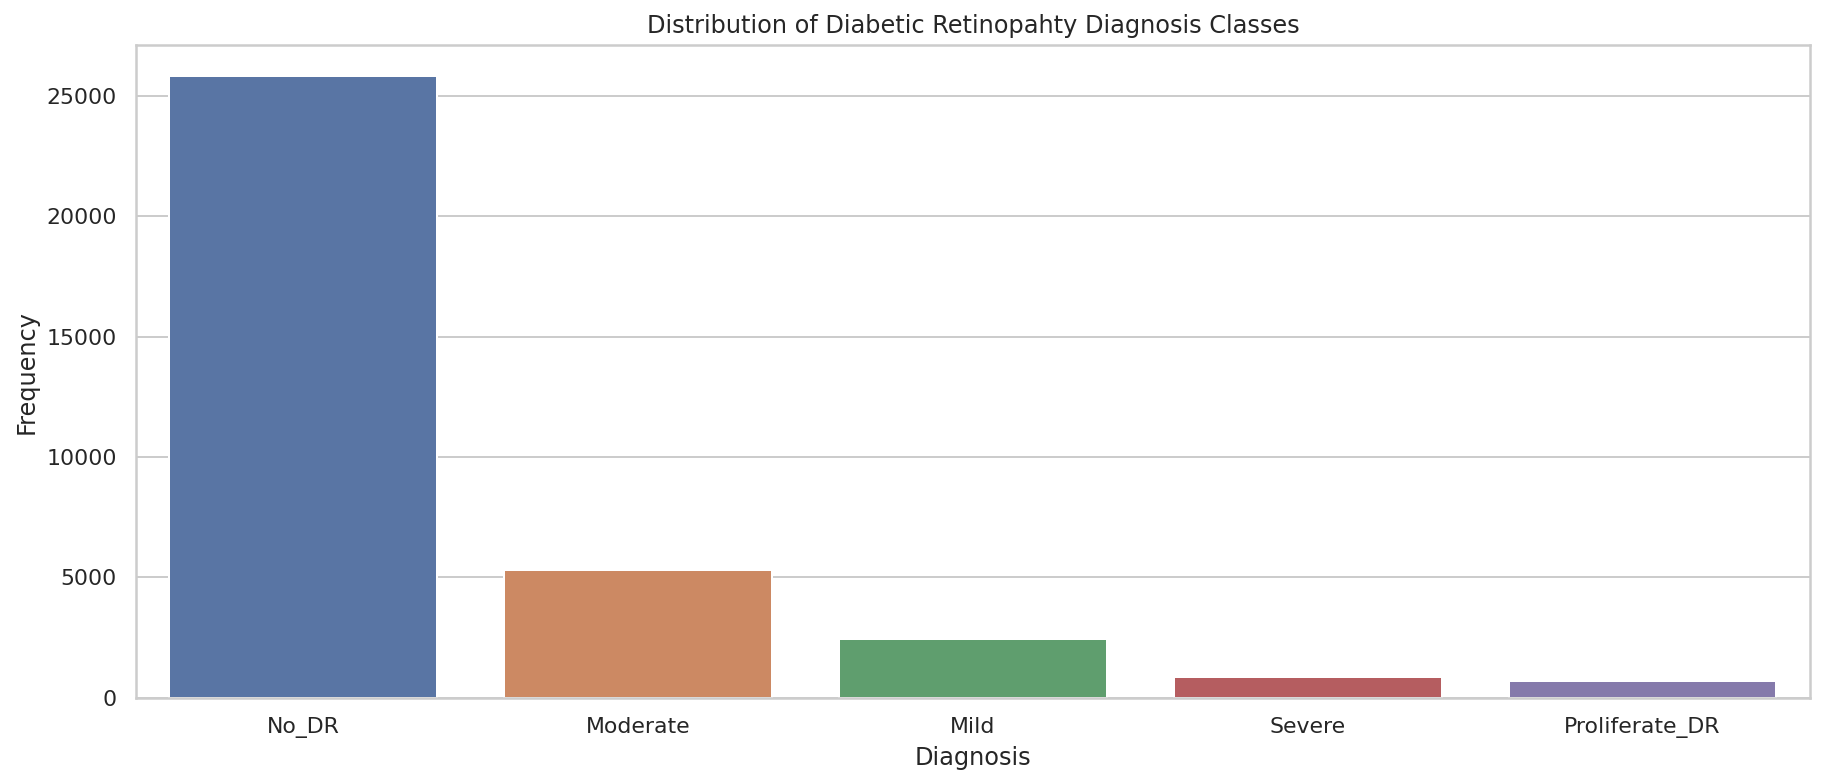

In [80]:
# distribution of diagnosis classes

plt.figure(figsize=(15,6))
sns.barplot(dataframe.diagnosis.value_counts().index,
            dataframe.diagnosis.value_counts(),
            palette=None)
plt.title("Distribution of Diabetic Retinopahty Diagnosis Classes")
plt.xlabel("Diagnosis")
plt.ylabel("Frequency");


Classes are unbalanced

No Diabetic Retinopthy
Datatype: <class 'PIL.PngImagePlugin.PngImageFile'>


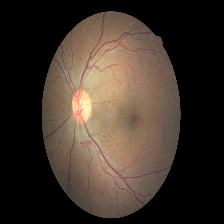

In [81]:
# view one healthy image

path = '/tmp/colored_images/colored_images/No_DR/10003_left.png'

healthy_image = tf.keras.preprocessing.image.load_img(
   path,
   grayscale=False, 
   color_mode="rgb", 
  #  target_size=(256, 256),
   interpolation="nearest")

print('No Diabetic Retinopthy')
print('Datatype:', type(healthy_image))
healthy_image 


Proliferate Diabetic Retinopthy
Datatype: <class 'PIL.PngImagePlugin.PngImageFile'>


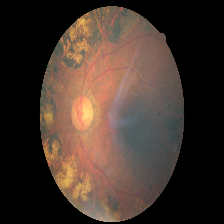

In [182]:
# view one proliferate DR image

path = '/tmp/colored_images/colored_images/Proliferate_DR/10017_left.png'

proliferate_image = tf.keras.preprocessing.image.load_img(
   path,
   grayscale=False, 
   color_mode="rgb", 
  #  target_size=(256, 256), 
   interpolation="nearest")

print('Proliferate Diabetic Retinopthy')
print('Datatype:', type(proliferate_image))
proliferate_image 


### Preprocessing<a id='tp'></a>  

In [83]:
# read in all images as a tensor BatchDataset
# https://keras.io/api/preprocessing/image/

directory = '/tmp/colored_images/colored_images'
databatch = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False )

print('Datatype:', type(databatch), '\n')
databatch

Found 35126 files belonging to 5 classes.
Datatype: <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'> 



<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [84]:
class_names = databatch.class_names
class_names

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

In [85]:
for image_batch, labels_batch in databatch:
  print('image_batch.shape', image_batch.shape)
  print('labels_batch.shape', labels_batch.shape)
  break

image_batch.shape (32, 256, 256, 3)
labels_batch.shape (32,)


image_batch = tensor 32 images, sized 256x256, 3 RBG colors

In [ ]:
# image and label batch arrays
image_batch_array = image_batch.numpy()
print('image batch array', image_batch_array)

labels_batch_array = labels_batch.numpy()
print('label batch array', labels_batch_array) 

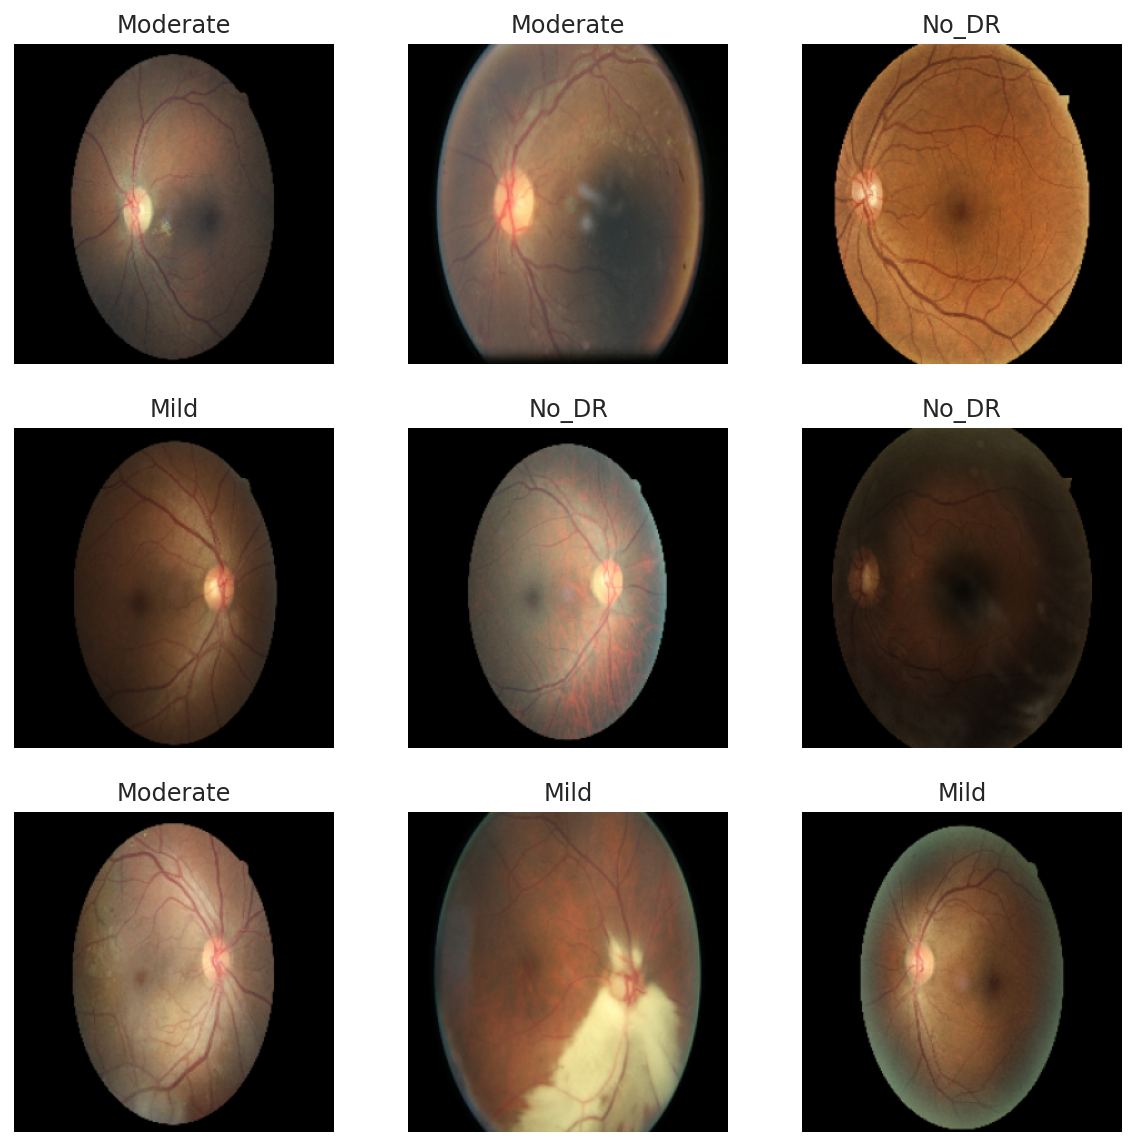

In [148]:
# show a sample of each diagnosis 

plt.figure(figsize=(10, 10))
for images, labels in databatch.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
# https://www.tensorflow.org/jvm/api_docs/java/org/tensorflow/op/data/BatchDataset

# convert healthy_image to numpy array

img = healthy_image
healthy_image_array = tf.keras.preprocessing.image.img_to_array(img, 
                                                                data_format=None, 
                                                                dtype=None)
print('Healthy Image Array')
print('type:', type(healthy_image_array))
healthy_image_array

https://www.h5py.org/
https://www.tensorflow.org/tutorials/images/cnn
https://www.tensorflow.org/tutorials/images/classification
https://www.tensorflow.org/tutorials/images/transfer_learning

## 3 | Baseline Model<a id='3'></a>  

In [ ]:
# loop over image in No_DR and Proliferate_DR (n=708)
# convert each image to an array to pass to baseline model 

# fetch all image paths
# for each image path: 
#   load image from image path
    # turn that image into a numpy array 
    # np.flatten the 2 array to 1D vector
    # save 1D vector to list 

#  if else for selecting only 2 folders: healthy and worse case  


https://www.geeksforgeeks.org/how-to-convert-images-to-numpy-array/
https://www.geeksforgeeks.org/how-to-iterate-through-images-in-a-folder-python/

### LogisticRegression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(DR_df[0], DR_df[1] 
                                                    test_size=0.2, random_state = 42)

# scale data?

print(X_train.shape)
print(y_train.shape)


In [ ]:
lr = LogisticRegression(C = 100)
lr.fit(X_train, y_train)
print('Simple logistic score: {}'.format(lr.score(X_test, y_test)))



## 4 | Deep Learning Model<a id='4'></a>  

Look at https://github.com/ngoodby/Metis-Deep-Learning-Project/blob/master/model_creation.ipynb
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb#scrollTo=pb2Af2lsUShk

### Validation Split

In [163]:
# train val split with data generator keras.util 
# https://github.com/crystal-ctrl/deep_learning_project/blob/main/workflow/2_CNN_binary(colab).ipynb


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os, shutil
from glob import glob
import cv2
from keras.preprocessing.image import ImageDataGenerator



image_gen = ImageDataGenerator(rescale=1./255)
train_dir = '/content/grive/MyDrive/Face Mask Dataset/Train'
val_dir = '/content/grive/MyDrive/Face Mask Dataset/Validation'
test_dir = '/content/grive/MyDrive/Face Mask Dataset/Test'


batch_size = 80
train_generator = image_gen.flow_from_directory(train_dir,
                                          target_size=(150,150),
                                          batch_size=batch_size,
                                          seed=42,
                                          shuffle=False,
                                          class_mode='binary')
val_generator = image_gen.flow_from_directory(val_dir,
                                        target_size=(150,150),
                                        batch_size=batch_size,
                                        seed=42,
                                        shuffle=False,
                                        class_mode='binary')
test_generator = image_gen.flow_from_directory(test_dir,
                                        target_size=(150,150),
                                        batch_size=batch_size,
                                        seed=42,
                                        shuffle=False,
                                        class_mode='binary')


In [ ]:
# https://github.com/mayaremington/deep-learn-echo/blob/main/2_deep_learn_echo_modeling.ipynb

# generator for training set

train_generator = tf.keras.preprocessing.image_dataset_from_directory(
    directory='drive/MyDrive/Project_6_Echo/Training_Images', 
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=32,
    image_size=(112, 112),
    seed=10)

# generator for validation set

val_generator = tf.keras.preprocessing.image_dataset_from_directory(
    directory='drive/My Drive/Project_6_Echo/Val_Images', 
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=32,
    image_size=(112, 112),
    seed=10)


# generator for testing set

test_generator = tf.keras.preprocessing.image_dataset_from_directory(
    directory='drive/My Drive/Project_6_Echo/Test_Images', 
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=32,
    image_size=(112, 112),
    seed=10)

In [177]:
num_classes = len(class_names)

model = Sequential([
    Rescaling(1./255, input_shape=(256, 256, 3)),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes)
])
model

In [178]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model

In [179]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)       

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 5 | Transfer Learning Model<a id='5'></a>  

## 6 | Predict


In [ ]:
# https://www.tensorflow.org/tutorials/images/classification


sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))

)

In [ ]:
# https://github.com/PurpleGrace/Deep_Learning_Tools_Image_Classification/blob/main/code/4%20Modes%20%20Evaluation.ipynb

index = np.random.choice(len(df_test_incorrect))
print(index)
#plt.figure(figsize= (12,8))
path = df_test_incorrect.iloc[index,0]
print(path,"\n")
img = IMG.load_img(path)  
x = IMG.img_to_array(img)  
plt.imshow(x/np.max(x))
plt.axis('off')


# print('The plot is a :',int_category_map.get(y_test_incorrect[index]))
# print('But classfied as a :',int_category_map.get(y_pred_incorrect[index]))

print('The plot is a :',df_test_incorrect.iloc[index,1])
print('But classfied as a :',df_test_incorrect.iloc[index,3])

In [ ]:
#plt.savefig('gdrive/MyDrive/saved_files/sample_%d.png' % (2))
